In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import os
from pickle import dump, load

from sklearn.model_selection import train_test_split

from keras import Input, layers, optimizers

from keras.preprocessing import sequence, image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential, Model

from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add

from keras.optimizers import Adam, RMSprop
from keras.utils import to_categorical

from lib.data.flickr_dataset import FlickrDataset
from lib.data.feature_vector_generator import FeatureVectorGenerator
from lib.data.glove_word_embedding_generator import GloveWordEmbeddingGenerator
from lib.data.generator.data_generator import DataGenerator

from lib.model.model_wrapper import ModelWrapper
from lib.model.metrics import rmse
from lib.model.greedy_search import GreedySearch

from lib.utils.word_utils import word_to_index_and_index_to_word
from lib.utils.file_utils import create_directory

from keras.callbacks import ModelCheckpoint
from lib.callback.metric_plotter import MetricsPlotter

Using TensorFlow backend.


In [3]:
data_path = "./dataset/data"
images_path = './dataset/images'
word_embedding_path = './dataset/glove.6B.200d.txt'
image_features_path = "./img_features.pkl"

In [4]:
dataset = FlickrDataset(
    data_path, 
    images_path,
    desc_prefix='$', 
    desc_postfix='#',
    clean_desc=True
)

Max len desc: $ an africanamerican man wear green sweatshirt and blue vest be hold up dollar bill in front of his face while stand on busy sidewalk in front of group of man play instrument #


In [5]:
train_samples, remain_samples = train_test_split(dataset.samples(), test_size=0.3)
val_samples, test_samples = train_test_split(remain_samples, test_size=0.1)
print(f'Train: {len(train_samples)}, Val: {len(val_samples)}, Test: {len(test_samples)}')

Train: 5663, Val: 2185, Test: 243


In [6]:
train_samples[0]

('./dataset/images/3216901052_269ace7b3c.jpg',
 ['$ child in red hat and scarf walk down snow cover street #',
  '$ child in winter clothes be walk along street #',
  '$ child run on street in snow #',
  '$ little kid play in the snow in brown jacket and red beanie #',
  '$ young child wear red hat and scarf play in street in little snow #'])

In [7]:
if not os.path.isfile(image_features_path):
    image_paths = list(dataset.samples().keys())
    image_features = list(FeatureVectorGenerator().generate(image_paths))
    with open(image_features_path, "wb") as encoded_pickle: dump(image_features, encoded_pickle)

image_features = dict(load(open(image_features_path, "rb")))

In [8]:
print(list(image_features.items())[0])

('./dataset/images/1305564994_00513f9a5b.jpg', array([0.06508796, 0.0321871 , 0.02376986, ..., 0.38368654, 0.1991062 ,
       0.23510437], dtype=float32))


In [9]:
min_occurs=10
vocabulary = dataset.words_set(min_occurs=10)
vocabulary_size = len(vocabulary)
complete_vocabulary_size = len(dataset.words_set())
print(f'Words(occurs>={min_occurs}): {vocabulary_size}/{complete_vocabulary_size}')

Words(occurs>=10): 1593/6688


In [10]:
word_to_index, index_to_word = word_to_index_and_index_to_word(vocabulary)

In [11]:
len(word_to_index)

1593

In [12]:
dataset.max_desc_len()

174

In [13]:
train_generator = DataGenerator(
    train_samples,
    image_features,
    word_to_index,
    index_to_word,
    dataset.max_desc_len(), 
    vocabulary_size,
    batch_size=3
)

val_generator = DataGenerator(
    val_samples,
    image_features,
    word_to_index,
    index_to_word,
    dataset.max_desc_len(), 
    vocabulary_size,
    batch_size=3
)

In [14]:
embedding_vector_dim = 200
embedding_generator = GloveWordEmbeddingGenerator(word_embedding_path, embedding_vector_dim)

In [15]:
embedding_matrix = embedding_generator.generate(word_to_index)

In [16]:
len(embedding_matrix)

1593



Metrics: ['loss', 'rmse']
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Description_Sequence (InputLaye (None, 174)          0                                            
__________________________________________________________________________________________________
Image_Feature (InputLayer)      (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 174, 200)     318600      Description_Sequence[0][0]       
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           Image_Feature[0][0]              
_________________________________________________________________________________

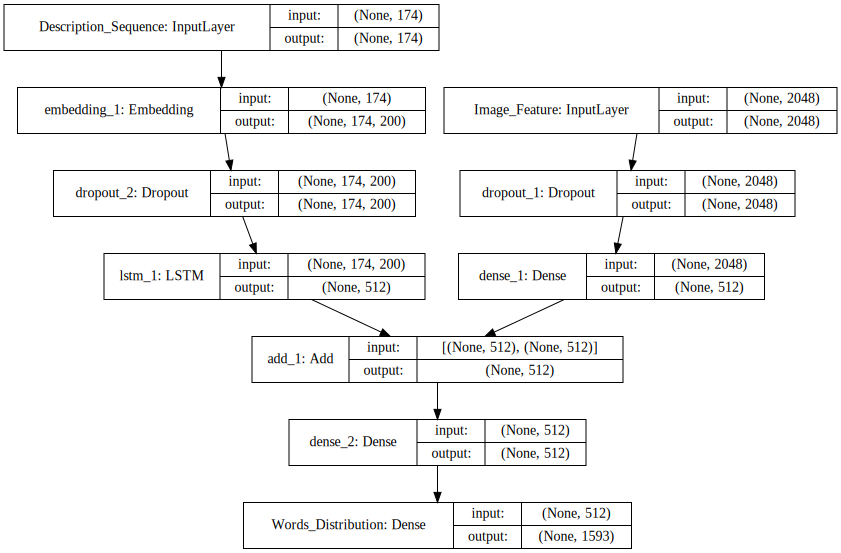

In [17]:
def build_model(vocabulary_size, embedding_vector_dim, embedding_matrix):
    img_feat_input = Input(name="Image_Feature", shape=(2048,))

    img_branch = Dropout(0.5)(img_feat_input)
    img_branch = Dense(512, activation='relu')(img_branch)

    seq_input = Input(name="Description_Sequence", shape=(dataset.max_desc_len(),))

    seq_branch = Embedding(vocabulary_size, embedding_vector_dim, mask_zero=True)(seq_input)
    seq_branch = Dropout(0.5)(seq_branch)
    seq_branch = LSTM(512)(seq_branch)

    decoder = add([img_branch, seq_branch])
    decoder = Dense(512, activation='relu')(decoder)

    outputs = Dense(name="Words_Distribution", units=vocabulary_size, activation='softmax')(decoder)

    model = Model(inputs=[img_feat_input, seq_input], outputs=outputs)

    model.layers[2].set_weights([embedding_matrix])
    model.layers[2].trainable = False

    model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam',
        metrics=[rmse]
    )

    return ModelWrapper(model)
    

model = build_model(vocabulary_size, embedding_vector_dim, embedding_matrix)
model.show()

In [18]:
batch_size = 16
weights_path = create_directory('weights')

callbacks = [
    ModelCheckpoint(
        weights_path + '/weights__epoch_{epoch:02d}__val_loss_{val_loss:.4f}__val_rmse_{val_rmse:.4f}.h5',
        monitor='val_loss', 
        verbose=1,
        save_best_only=True, 
        save_weights_only=True, 
        mode='auto',
        period=1
    ),
    MetricsPlotter(
        validation_generator=val_generator,
        plot_interval=30,
        evaluate_interval=30,
        batch_size=batch_size
    )
]

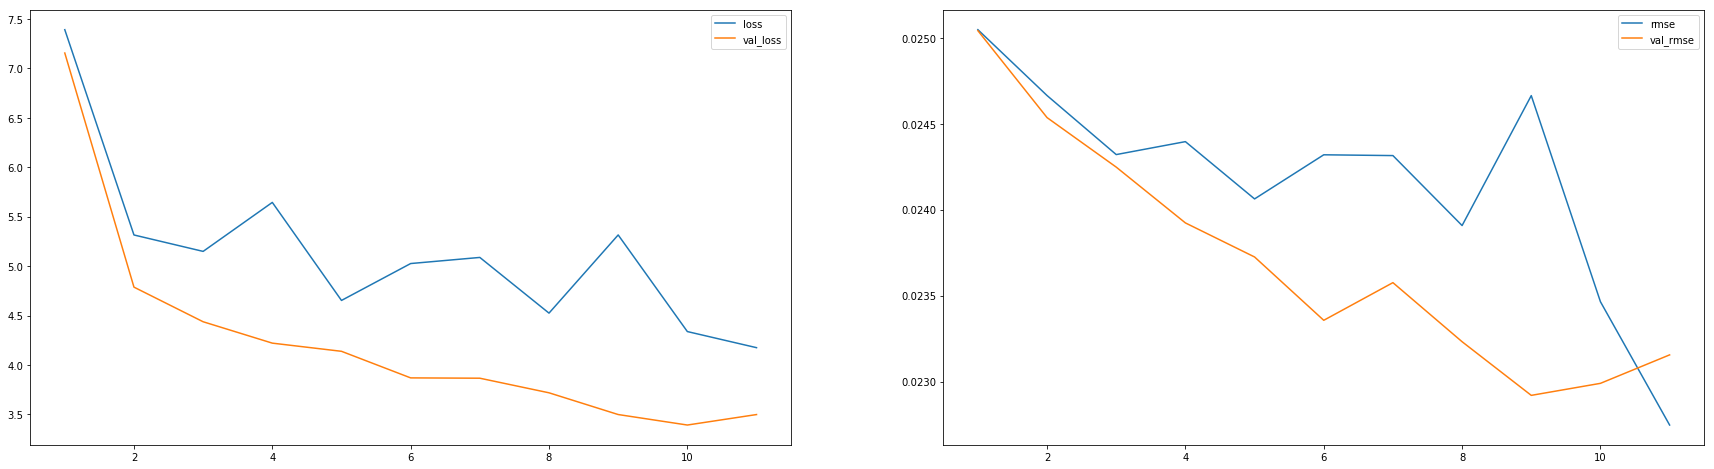



Evaluate model (Each 30 steps):
139/139 [==============================] - 1s 4ms/step

Validation:
  - Loss (12): 3.358907 (⟱ 0.14026211)
  - Rmse (12): 0.022981 (⟱ 0.00017405)

Continue model train:
353/353 [============================>.] - ETA: 0s - loss: 4.8145 - rmse: 0.0241

In [ ]:
model.fit(
    train_generator,
    val_generator,
    epochs=10,
    steps_per_epoch=len(train_samples)/batch_size,
    callbacks=callbacks
)

In [ ]:
model.lr(0.0001).fit(
    train_generator,
    val_generator,
    epochs=10,
    steps_per_epoch=len(train_samples),
    callbacks=callbacks
)

In [ ]:
search = GreedySearch(model, word_to_index, index_to_word, '$', '#', dataset.max_desc_len())

image_path = test_samples[0][0]

show_sample(
    image_path,
    description=search.perform( image_features[image_path])
)